<a href="https://colab.research.google.com/github/zhaoxiaoer/ml/blob/main/src/2021/hw3/hw03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 3 - Convolutional Neural Network**

This is the example code of homework 3 of the machine learning course by Prof. Hung-yi Lee.

In this homework, you are required to build a convolutional neural network for image classification, possibly with some advanced training tips.

There are three levels here:

**Easy**: Build a simple convolutional neural network as the baseline. (2 pts)

**Medium**: Design a better architecture or adopt different data augmentations to improve the performance. (2 pts)

**Hard**: Utilize provided unlabeled data to obtain better results. (2 pts)

## **About the Dataset**

The dataset used here is food-11, a collection of food images in 11 classes.

For the requirement in the homework, TAs slightly modified the data. Please DO NOT access the original fully-labeled training data or testing labels.

Also, the modified dataset is for this course only, and any further distribution or commercial use is forbidden.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab\ Notebooks/hw3
!ls

/content/drive/MyDrive/Colab Notebooks/hw3
food-11  food-11.zip  hw03.ipynb  predict.csv


In [ ]:
# Download the dataset
# You may choose where to download the data.

# Google Drive
!gdown --id '1awF7pZ9Dz7X1jn1_QAiKN-_v56veCEKy' --output food-11.zip

# Unzip the dataset.
# This may take some time.
!unzip -q food-11.zip

Downloading...
From: https://drive.google.com/uc?id=1awF7pZ9Dz7X1jn1_QAiKN-_v56veCEKy
To: /content/drive/MyDrive/Colab Notebooks/hw3/food-11.zip
963MB [00:07, 126MB/s]


In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks/hw3/food-11/testing/00
from PIL import Image
im = Image.open('0000.jpg')
im
# im.show()

## **Import Packages**

First, we need to import packages that will be used later.

In this homework, we highly rely on **torchvision**, a library of PyTorch.

In [3]:
# Import necessary packages.
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset
from torchvision.datasets import DatasetFolder

import torchvision.models as models
import matplotlib.pyplot as plt

# This is for the progress bar.
from tqdm.auto import tqdm

## **Dataset, DataLoader, and Transforms**

Torchvision provides lots of useful utilities for image preprocessing, data wrapping as well as data augmentation.

Here, since our data are stored in folders by class labels, we can directly apply **torchvision.datasets.DatasetFolder** for wrapping data without much effort.

Please refer to [PyTorch official website](https://pytorch.org/vision/stable/transforms.html) for details about different transforms.

In [4]:
# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for food recognition.
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    # You may add some transforms here.
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])

# We don't need augmentation in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [5]:
# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 128

# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = DatasetFolder("food-11/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
valid_set = DatasetFolder("food-11/validation", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
unlabeled_set = DatasetFolder("food-11/training/unlabeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
test_set = DatasetFolder("food-11/testing", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

# Construct data loaders.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


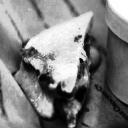

In [13]:
iterator = iter(train_set)
img_label = next(iterator)
img_label = next(iterator)
img_label = next(iterator)
# img_label
# img_label[0]
img_label[0].shape
img = Image.fromarray(img_label[0][0].numpy() * 255)
img.convert('L')

In [ ]:
iterator = iter(train_loader)
img_labels = next(iterator)
img_labels

## **Model**

The basic model here is simply a stack of convolutional layers followed by some fully-connected layers.

Since there are three channels for a color image (RGB), the input channels of the network must be three.
In each convolutional layer, typically the channels of inputs grow, while the height and width shrink (or remain unchanged, according to some hyperparameters like stride and padding).

Before fed into fully-connected layers, the feature map must be flattened into a single one-dimensional vector (for each image).
These features are then transformed by the fully-connected layers, and finally, we abtain the "logits" for each class.

### **WARNING -- You Must Know**
You are free to modify the model architecture here for further improvement.
However, if you want to use some well-known architectures such as ResNet50, please make sure **NOT** to load the pre-trained weights.
Using such pre-trained models is considered cheating and therefore you will be punished.
Similarly, it is your responsibility to make sure no pre-trained weights are used if you use **torch.hub** to load any modules.

For example, if you use ResNet-18 as your model:

model = torchvision.models.resnet18(pretrained=**False**) → This is fine.

model = torchvision.models.resnet18(pretrained=**True**) → This is **NOT** allowed.

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # The arguments for commonly used modules:
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)

        # input image size: [3, 128, 128]
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            nn.Dropout2d(),                # 加入dropout层后，效果反而不好，暂时不清楚怎么回事

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            nn.Dropout2d(),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(4, 4, 0),
            nn.Dropout2d(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 11)
        )

    def forward(self, x):
      # input (x): [batch_size, 3, 128, 128]
      # output: [batch_size, 11]

      # Extract features by convolutional layers.
      x = self.cnn_layers(x)

      # The extracted feature map must be flatten before going to fully-connected layers.
      x = x.flatten(1)

      # The features are transformed by fully-connected layers to obtain the final logits.
      x = self.fc_layers(x)
      return x

In [ ]:
# 测试卷积
conv = nn.Conv2d(1, 2, 3, 1, 1)
# print(list(conv.parameters()))
print(conv.weight)
print(conv.bias)
inputs = torch.ones((1, 1, 3, 3))
print(inputs)
outputs = conv(inputs)
print(outputs)
print(outputs.shape)

Parameter containing:
tensor([[[[-0.2585, -0.2364, -0.0975],
          [-0.2955, -0.2437, -0.0342],
          [ 0.0965,  0.1920,  0.3065]]],


        [[[-0.1786,  0.2334,  0.1386],
          [-0.3060,  0.2473,  0.1413],
          [ 0.1377, -0.0194, -0.0411]]]], requires_grad=True)
Parameter containing:
tensor([0.0601, 0.2576], requires_grad=True)
tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]])
tensor([[[[ 0.2808,  0.0817, -0.1907],
          [-0.0532, -0.5108, -0.6856],
          [-0.5518, -1.1058, -0.9741]],

         [[ 0.5857,  0.4175,  0.3173],
          [ 0.9577,  0.6108,  0.3720],
          [ 1.0182,  0.5335,  0.2536]]]], grad_fn=<ThnnConv2DBackward>)
torch.Size([1, 2, 3, 3])


In [ ]:
# 测试批标准化
batchNorm = nn.BatchNorm2d(2)
outputs = batchNorm(outputs)
print(outputs)

tensor([[[[ 1.5482,  1.1035,  0.4949],
          [ 0.8020, -0.2203, -0.6110],
          [-0.3120, -1.5497, -1.2555]],

         [[ 0.0899, -0.5727, -0.9673],
          [ 1.5544,  0.1884, -0.7518],
          [ 1.7926, -0.1157, -1.2178]]]], grad_fn=<NativeBatchNormBackward>)


In [ ]:
# 测试激活
relu = nn.ReLU()
outputs = relu(outputs)
print(outputs)

tensor([[[[1.5482, 1.1035],
          [0.8020, 0.0000]],

         [[1.5544, 0.1884],
          [1.7926, 0.1884]]]], grad_fn=<ReluBackward0>)


In [ ]:
# 测试Pooling
pooling = nn.MaxPool2d(2, 1, 0)
outputs = pooling(outputs)
print(outputs)

tensor([[[[1.5482, 1.1035],
          [0.8020, 0.0000]],

         [[1.5544, 0.1884],
          [1.7926, 0.1884]]]], grad_fn=<MaxPool2DWithIndicesBackward>)


## **Training**

You can finish supervised learning by simply running the provided code without any modification.

The function "get_pseudo_labels" is used for semi-supervised learning. It is expected to get better performance if you use unlabeled data for semi-supervised learning.
However, you have to implement the function on your own and need to adjust several hyperparameters manually.

For more details about semi-supervised learning, please refer to [Prof. Lee's slides](https://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/semi%20(v3).pdf).

Again, please notice that utilizing external data (or pre-trained model) for training is **prohibited**.

In [ ]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
# model = Classifier().to(device)
model = models.resnet18(pretrained=False).to(device)
model.device = device

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)

In [ ]:
# The number of training epochs.
n_epochs = 80

# Whether to do semi-supervised learning.
do_semi = False

# draw picture
train_loss_list = []
train_accs_list = []
valid_loss_list = []
valid_accs_list = []

for epoch in range(n_epochs):

    # ------------ Training -------------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []
    valid_loss = []
    valid_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    train_loss_list.append(train_loss)
    train_accs_list.append(train_acc)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ----------- Validation -------------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))
        
        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
    
    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    valid_loss_list.append(valid_loss)
    valid_accs_list.append(valid_acc)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



[ Train | 001/080 ] loss = 4.01653, acc = 0.15187



[ Valid | 001/080 ] loss = 3.46751, acc = 0.08516



[ Train | 002/080 ] loss = 2.14922, acc = 0.26063



[ Valid | 002/080 ] loss = 2.27676, acc = 0.22526



[ Train | 003/080 ] loss = 2.06002, acc = 0.27531



[ Valid | 003/080 ] loss = 2.02761, acc = 0.26693



[ Train | 004/080 ] loss = 1.98102, acc = 0.31094



[ Valid | 004/080 ] loss = 2.16520, acc = 0.29714



[ Train | 005/080 ] loss = 1.89711, acc = 0.32969



[ Valid | 005/080 ] loss = 1.93891, acc = 0.30182



[ Train | 006/080 ] loss = 1.79527, acc = 0.39031



[ Valid | 006/080 ] loss = 2.31048, acc = 0.25078



[ Train | 007/080 ] loss = 1.72791, acc = 0.42125



[ Valid | 007/080 ] loss = 1.98340, acc = 0.32839



[ Train | 008/080 ] loss = 1.61152, acc = 0.46031



[ Valid | 008/080 ] loss = 2.15827, acc = 0.31068



[ Train | 009/080 ] loss = 1.53788, acc = 0.48031



[ Valid | 009/080 ] loss = 2.08163, acc = 0.33411



[ Train | 010/080 ] loss = 1.40886, acc = 0.54562



[ Valid | 010/080 ] loss = 1.91314, acc = 0.36745



[ Train | 011/080 ] loss = 1.33902, acc = 0.55750



[ Valid | 011/080 ] loss = 2.37280, acc = 0.28021



[ Train | 012/080 ] loss = 1.21524, acc = 0.60469



[ Valid | 012/080 ] loss = 3.25614, acc = 0.25521



[ Train | 013/080 ] loss = 1.04226, acc = 0.67094



[ Valid | 013/080 ] loss = 1.93335, acc = 0.41641



[ Train | 014/080 ] loss = 1.07593, acc = 0.65187



[ Valid | 014/080 ] loss = 2.88803, acc = 0.24661



[ Train | 015/080 ] loss = 0.99034, acc = 0.68969



[ Valid | 015/080 ] loss = 2.50860, acc = 0.34245



[ Train | 016/080 ] loss = 0.93688, acc = 0.70531



[ Valid | 016/080 ] loss = 2.11859, acc = 0.42682



[ Train | 017/080 ] loss = 0.87504, acc = 0.72219



[ Valid | 017/080 ] loss = 2.65578, acc = 0.33516



[ Train | 018/080 ] loss = 0.86482, acc = 0.72406



[ Valid | 018/080 ] loss = 2.12119, acc = 0.39323



[ Train | 019/080 ] loss = 0.78750, acc = 0.75094



[ Valid | 019/080 ] loss = 2.21422, acc = 0.37057



[ Train | 020/080 ] loss = 0.78524, acc = 0.74969



[ Valid | 020/080 ] loss = 2.54866, acc = 0.34089



[ Train | 021/080 ] loss = 0.77410, acc = 0.76063



[ Valid | 021/080 ] loss = 2.49421, acc = 0.34557



[ Train | 022/080 ] loss = 0.70618, acc = 0.78250



[ Valid | 022/080 ] loss = 2.08515, acc = 0.40286



[ Train | 023/080 ] loss = 0.65596, acc = 0.79906



[ Valid | 023/080 ] loss = 2.50839, acc = 0.36562



[ Train | 024/080 ] loss = 0.69226, acc = 0.78312



[ Valid | 024/080 ] loss = 2.45403, acc = 0.35260



[ Train | 025/080 ] loss = 0.67794, acc = 0.80125



[ Valid | 025/080 ] loss = 2.41297, acc = 0.36198



[ Train | 026/080 ] loss = 0.61508, acc = 0.80875



[ Valid | 026/080 ] loss = 2.51071, acc = 0.38385



[ Train | 027/080 ] loss = 0.59285, acc = 0.80594



[ Valid | 027/080 ] loss = 2.59207, acc = 0.37474



[ Train | 028/080 ] loss = 0.63265, acc = 0.80094



[ Valid | 028/080 ] loss = 2.64671, acc = 0.33255



[ Train | 029/080 ] loss = 0.62138, acc = 0.79469



[ Valid | 029/080 ] loss = 2.15802, acc = 0.38021



[ Train | 030/080 ] loss = 0.53932, acc = 0.83500



[ Valid | 030/080 ] loss = 2.64500, acc = 0.37161



[ Train | 031/080 ] loss = 0.57168, acc = 0.82094



[ Valid | 031/080 ] loss = 2.26277, acc = 0.39557



[ Train | 032/080 ] loss = 0.47732, acc = 0.84812



[ Valid | 032/080 ] loss = 2.28550, acc = 0.40703



[ Train | 033/080 ] loss = 0.55836, acc = 0.82250



[ Valid | 033/080 ] loss = 2.45135, acc = 0.37422



[ Train | 034/080 ] loss = 0.53882, acc = 0.82781



[ Valid | 034/080 ] loss = 2.30314, acc = 0.41875



[ Train | 035/080 ] loss = 0.45879, acc = 0.86031



[ Valid | 035/080 ] loss = 2.49330, acc = 0.40260



[ Train | 036/080 ] loss = 0.50287, acc = 0.84938



[ Valid | 036/080 ] loss = 2.48281, acc = 0.42188



[ Train | 037/080 ] loss = 0.52353, acc = 0.83562



[ Valid | 037/080 ] loss = 2.16487, acc = 0.43828



[ Train | 038/080 ] loss = 0.42512, acc = 0.86312



[ Valid | 038/080 ] loss = 2.68739, acc = 0.38906



[ Train | 039/080 ] loss = 0.47307, acc = 0.84906



[ Valid | 039/080 ] loss = 3.27965, acc = 0.32708



[ Train | 040/080 ] loss = 0.41818, acc = 0.86562



[ Valid | 040/080 ] loss = 2.39069, acc = 0.41484



[ Train | 041/080 ] loss = 0.42861, acc = 0.87156



[ Valid | 041/080 ] loss = 2.34343, acc = 0.39948



[ Train | 042/080 ] loss = 0.45344, acc = 0.86281



[ Valid | 042/080 ] loss = 2.37466, acc = 0.42526



[ Train | 043/080 ] loss = 0.41331, acc = 0.87031



[ Valid | 043/080 ] loss = 2.19982, acc = 0.45260



[ Train | 044/080 ] loss = 0.41268, acc = 0.86625



[ Valid | 044/080 ] loss = 2.81496, acc = 0.38099



[ Train | 045/080 ] loss = 0.39943, acc = 0.87094



[ Valid | 045/080 ] loss = 2.34214, acc = 0.38073



[ Train | 046/080 ] loss = 0.40222, acc = 0.87281



[ Valid | 046/080 ] loss = 2.76210, acc = 0.39740



[ Train | 047/080 ] loss = 0.38219, acc = 0.87906



[ Valid | 047/080 ] loss = 2.61850, acc = 0.38021



[ Train | 048/080 ] loss = 0.38566, acc = 0.88563



[ Valid | 048/080 ] loss = 2.67313, acc = 0.38880



[ Train | 049/080 ] loss = 0.35697, acc = 0.88250



[ Valid | 049/080 ] loss = 2.64280, acc = 0.34115



[ Train | 050/080 ] loss = 0.35605, acc = 0.88187



[ Valid | 050/080 ] loss = 2.43484, acc = 0.37839



[ Train | 051/080 ] loss = 0.32059, acc = 0.89406



[ Valid | 051/080 ] loss = 2.33182, acc = 0.40000



[ Train | 052/080 ] loss = 0.32784, acc = 0.89750



[ Valid | 052/080 ] loss = 2.79234, acc = 0.39349



[ Train | 053/080 ] loss = 0.35163, acc = 0.88719



[ Valid | 053/080 ] loss = 2.63722, acc = 0.39922



[ Train | 054/080 ] loss = 0.37604, acc = 0.89156



[ Valid | 054/080 ] loss = 2.55223, acc = 0.35182



[ Train | 055/080 ] loss = 0.31433, acc = 0.90094



[ Valid | 055/080 ] loss = 2.42075, acc = 0.34766



[ Train | 056/080 ] loss = 0.33369, acc = 0.88687



[ Valid | 056/080 ] loss = 2.69460, acc = 0.38203



[ Train | 057/080 ] loss = 0.31465, acc = 0.90469



[ Valid | 057/080 ] loss = 2.46800, acc = 0.43854



[ Train | 058/080 ] loss = 0.33409, acc = 0.88875



[ Valid | 058/080 ] loss = 2.36925, acc = 0.42812



[ Train | 059/080 ] loss = 0.32578, acc = 0.90062



[ Valid | 059/080 ] loss = 2.43957, acc = 0.42500



[ Train | 060/080 ] loss = 0.29256, acc = 0.91000



[ Valid | 060/080 ] loss = 2.57890, acc = 0.42266



[ Train | 061/080 ] loss = 0.29618, acc = 0.90687



[ Valid | 061/080 ] loss = 2.43014, acc = 0.41536



[ Train | 062/080 ] loss = 0.27156, acc = 0.91500



[ Valid | 062/080 ] loss = 2.88283, acc = 0.38255



[ Train | 063/080 ] loss = 0.28454, acc = 0.91031



[ Valid | 063/080 ] loss = 2.54332, acc = 0.41563



[ Train | 064/080 ] loss = 0.28316, acc = 0.91125



[ Valid | 064/080 ] loss = 2.34882, acc = 0.42318



[ Train | 065/080 ] loss = 0.25803, acc = 0.92031



[ Valid | 065/080 ] loss = 2.58943, acc = 0.41667



[ Train | 066/080 ] loss = 0.25286, acc = 0.92031



[ Valid | 066/080 ] loss = 3.28082, acc = 0.35000



[ Train | 067/080 ] loss = 0.22540, acc = 0.92875



[ Valid | 067/080 ] loss = 2.43483, acc = 0.41510



[ Train | 068/080 ] loss = 0.28421, acc = 0.90750



[ Valid | 068/080 ] loss = 2.91239, acc = 0.37240



[ Train | 069/080 ] loss = 0.26722, acc = 0.90594



[ Valid | 069/080 ] loss = 2.71793, acc = 0.40755



[ Train | 070/080 ] loss = 0.26363, acc = 0.91281



[ Valid | 070/080 ] loss = 2.66906, acc = 0.39271



[ Train | 071/080 ] loss = 0.21827, acc = 0.93344



[ Valid | 071/080 ] loss = 3.27449, acc = 0.32292



[ Train | 072/080 ] loss = 0.22137, acc = 0.92906



[ Valid | 072/080 ] loss = 2.68419, acc = 0.38698



[ Train | 073/080 ] loss = 0.23051, acc = 0.92844



[ Valid | 073/080 ] loss = 2.64730, acc = 0.39948



[ Train | 074/080 ] loss = 0.24276, acc = 0.92719



[ Valid | 074/080 ] loss = 2.50635, acc = 0.40911



[ Train | 075/080 ] loss = 0.25335, acc = 0.92156



[ Valid | 075/080 ] loss = 2.42957, acc = 0.45599



[ Train | 076/080 ] loss = 0.22333, acc = 0.93250



[ Valid | 076/080 ] loss = 2.57323, acc = 0.42630


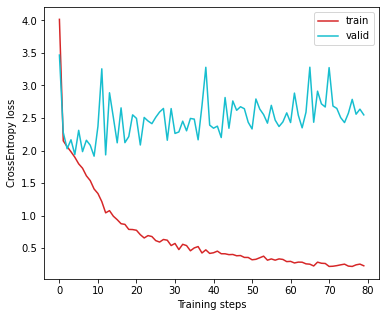

In [ ]:
plt.figure(figsize=(6, 5))
plt.plot(train_loss_list, c="tab:red", label="train")
plt.plot(valid_loss_list, c="tab:cyan", label="valid")
plt.xlabel("Training steps")
plt.ylabel("CrossEntropy loss")
plt.legend()
plt.show()

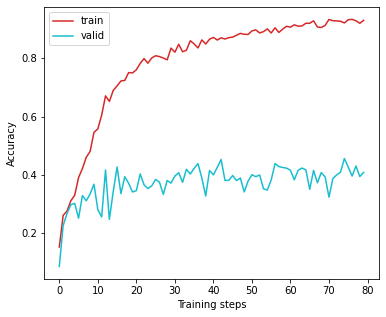

In [ ]:
plt.figure(figsize=(6, 5))
plt.plot(train_accs_list, c="tab:red", label="train")
plt.plot(valid_accs_list, c="tab:cyan", label="valid")
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## **Testing**

for inference, we need to make sure the model is in eval mode, and the order of the dataset should not be shuffled ("shuffle=False" in test_loader).

Last but not least, don't forget to save the predictions into a single CSV file.
The format of CSV file should follow the rules mentioned in the slides.

In [ ]:
# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
model.eval()

# Initialize a list to store the predictions.
predictions = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    # But here the variable "labels" is useless since we do not have the ground-truth.
    # If printing out the labels, you will find that it is always 0.
    # This is because the wrapper (DatasetFolder) returns images and labels for each batch,
    # so we have to create fake labels to make it work normally.
    imgs, labels = batch

    # We don't need gradient in testing, and we don't even have labels to compute loss.
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
        logits = model(imgs.to(device))

    # Take the class with greatest logit as prediction and record it.
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

KeyboardInterrupt: ignored

In [ ]:
# Save predictions into the file.
with open("predict.csv", "w") as f:
    f.write("Id,Category\n")
    
    for i, pred in enumerate(predictions):
        f.write(f"{i},{pred}\n")